In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 8
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/slides/lecture_4_2"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [2]:
#| echo: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("Optim")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("LineSearches")

  Activating project at `~/local_repos/AGEC652_2024/slides/lecture_4_2`


Precompiling project...


  ✓ Plots → UnitfulExt
  1 dependency successfully precompiled in 5 seconds. 176 already precompiled.


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_4_2/Manifest.toml`


In [3]:
using Optim, Plots, LinearAlgebra;
a = 1; b = 4; c = -2; d = -1; e = -3;
f(x) = a*x[1]^2 + b*x[2]^2 + c*x[1] + d*x[2] + e*x[1]*x[2];

In [4]:
curve_levels = exp.(0:log(1.2):log(500)) .- 5; # Define manual, log-scale levels for a nicer look

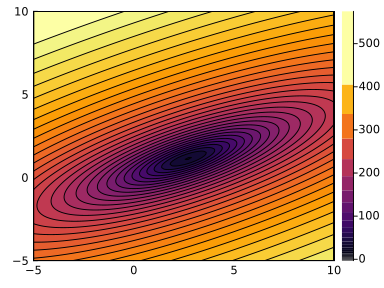

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:577


In [5]:
Plots.contour(-5.0:0.1:10.0, -5:0.1:10.0, (x,y)->f([x, y]),
              fill = true, levels = curve_levels, size = (400, 300))

In [6]:
# Gradient
function g!(G, x)
    G[1] = 2a*x[1] + c + e*x[2]
    G[2] = 2b*x[2] + d + e*x[1]
end;

# Hessian
function h!(H, x)
    H[1,1] = 2a
    H[1,2] = e
    H[2,1] = e
    H[2,2] = 2b
end;

In [7]:
H = zeros(2,2);
h!(H, [0 0]);
LinearAlgebra.eigen(H).values

2-element Vector{Float64}:
 0.7573593128807148
 9.242640687119286

In [8]:
analytic_x_star = [2a e; e 2b]\[-c ;-d]

2-element Vector{Float64}:
 2.714285714285715
 1.142857142857143

In [9]:
# Initial guess
x0 = [0.2, 1.6]; 
res_GD = Optim.optimize(f, g!, x0, GradientDescent(), Optim.Options(x_abstol=1e-3))

 * Status: success

 * Candidate solution
    Final objective value:     -3.285714e+00

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 4.55e-04 ≤ 1.0e-03
    |x - x'|/|x'|          = 1.68e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.80e-07 ≰ 0.0e+00
    |g(x)|                 = 4.83e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    9
    f(x) calls:    27
    ∇f(x) calls:   27


In [10]:
res_GD.minimizer

2-element Vector{Float64}:
 2.7136160576693604
 1.1425715540060508

In [11]:
res_GD.minimum

-3.285714084769726

In [12]:
using LineSearches;

In [13]:
Optim.optimize(f, g!, x0,
               GradientDescent(alphaguess = LineSearches.InitialStatic(alpha=1.0),
                               linesearch = BackTracking()),
               Optim.Options(x_abstol=1e-3))

 * Status: success

 * Candidate solution
    Final objective value:     -3.285714e+00

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 3.61e-04 ≤ 1.0e-03
    |x - x'|/|x'|          = 1.33e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.65e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.63e-07 ≰ 0.0e+00
    |g(x)|                 = 6.73e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    18
    ∇f(x) calls:   12


In [14]:
Optim.optimize(f, g!, h!, x0, Newton())

 * Status: success

 * Candidate solution
    Final objective value:     -3.285714e+00

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 2.51e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.26e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.06e+01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.23e+00 ≰ 0.0e+00
    |g(x)|                 = 1.78e-15 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    2
    ∇f(x) calls:   2
    ∇²f(x) calls:  1


In [15]:
Optim.optimize(f, x0, BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     -3.285714e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.81e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.67e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.47e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.48e-01 ≰ 0.0e+00
    |g(x)|                 = 1.28e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6


In [16]:
a = 1; b = 4; c = -2; d = -1; e = -3;
f(x) = a*x[1]^2 + b*x[2]^2 + c*x[1] + d*x[2] + e*x[1]*x[2];
res = Optim.optimize(f, g!, h!, x0, NewtonTrustRegion());
print(res)

 * Status: success

 * Candidate solution
    Final objective value:     -3.285714e+00

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 1.85e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.83e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.15e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.54e-01 ≰ 0.0e+00
    |g(x)|                 = 8.88e-16 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    3
    ∇f(x) calls:   3
    ∇²f(x) calls:  3
